# Survival Analysis of Different Drug Treatments

**Import Modules and set up dataframe using uis.csv dataset**

In [163]:
from lifelines import CoxPHFitter,KaplanMeierFitter,logrank_test
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import *
from lifelines.plotting import plot_lifetimes as lplt


df = pd.read_csv('/Users/johnnyperez/Desktop/SQL JOB/Projects/PROJECT 5/uis.csv')

df_r = df.loc[:,["age","ndrugtx","treat","site","time","censor","herco"]]

**What the UIS Data Looks like**

In [149]:
df_r.head()

,age,ndrugtx,treat,site,time,censor,herco
0,39.0,1.0,1,0,188,1,3
1,33.0,8.0,1,0,26,1,3
2,33.0,3.0,1,0,207,1,2
3,32.0,1.0,0,0,144,1,3
4,24.0,5.0,1,0,551,0,2


The goal of the UIS data is to model time until return to drug use for patients enrolled in two different residential treatment programs that differed in length (treat=0 is the short program and treat=1 is the long program).  The patients were randomly assigned to two different sites (site=0 is site A and site=1 is site B).  The variable age indicates age at enrollment, herco indicates heroin or cocaine use in the past three months (herco=1 indicates heroin and cocaine use, herco=2 indicates either heroin or cocaine use and herco=3 indicates neither heroin nor cocaine use) and ndrugtx indicates the number of previous drug treatments.  The variables time contains the time until return to drug use and the censor variable indicates whether the subject returned to drug use (censor=1 indicates return to drug use and censor=0 otherwise).

**Varience in the Dataset**

In [156]:
categories = [i  for i in df_r.columns]

categories.remove('age')
categories.remove('time')
categories.remove('ndrugtx')

for cat in categories:
    print('Column Name: ',cat)
    print(df_r[cat].value_counts())
    print('-----------------------------')
    i+=1

Column Name:  treat
0    320
1    308
Name: treat, dtype: int64
-----------------------------
Column Name:  site
0    444
1    184
Name: site, dtype: int64
-----------------------------
Column Name:  censor
1    508
0    120
Name: censor, dtype: int64
-----------------------------
Column Name:  herco
1    289
3    225
2    114
Name: herco, dtype: int64
-----------------------------


**Why are we using Survival Analysis**

In the figure below, the red lines denote the lifespan of individuals where the death event has been observed, and the blue lines denote the lifespan of the right-censored individuals (deaths have not been observed). If we are asked to estimate the average lifetime of our population, and we naively decided to not included the right-censored individuals, it is clear that we would be severely underestimating the true average lifespan.

Text(0.5, 1.0, 'Time to treat our population, at $t=300$')

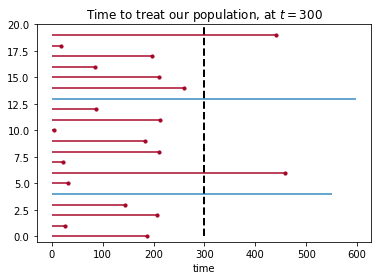

In [189]:
from lifelines.plotting import plot_lifetimes
T = df_r['time']
T = T[:20]
E = df_r['censor']
E = E[:20]


ax = plot_lifetimes(T,E)

ax.vlines(300, 0, 30, lw=2, linestyles='--')
ax.set_xlabel("time")
ax.set_title("Time to treat our population, at $t=300$")


**Univariate Analysis**

In survival analysis it is highly recommended to look at the Kaplan-Meier curves for all the categorical predictors. This will provide insight into the shape of the survival function for each group and give an idea of whether or not the groups are proportional (i.e. the survival functions are approximately parallel). 

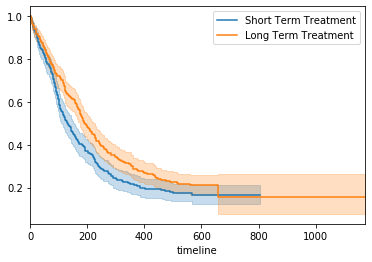

In [167]:
T = df_r['time']
C = df_r['censor']

groups = df_r['treat']           
short = (groups == 0)  
long = (groups == 1)         

kmf = KaplanMeierFitter()

kmf.fit(T[short], C[short], label='Short Term Treatment')    ## fit the cohort 1 data
ax = kmf.plot()


kmf.fit(T[long], C[long], label='Long Term Treatment')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax1)

kmf.plot()

In [164]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues
print(calculate_pvalues(df_r))

            age ndrugtx   treat    site    time  censor   herco
age           0       0  0.2576  0.3047  0.0823  0.1322  0.2819
ndrugtx       0       0  0.8529  0.0201  0.0009  0.0005   0.005
treat    0.2576  0.8529       0  0.5354  0.0061  0.2605  0.0589
site     0.3047  0.0201  0.5354       0  0.2121  0.2896  0.0042
time     0.0823  0.0009  0.0061  0.2121       0       0  0.5569
censor   0.1322  0.0005  0.2605  0.2896       0       0  0.6983
herco    0.2819   0.005  0.0589  0.0042  0.5569  0.6983       0


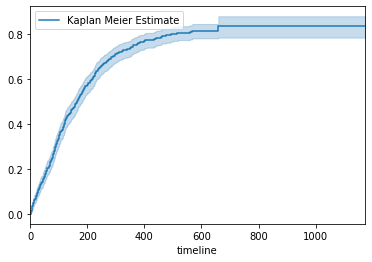

In [136]:
kmf.plot_cumulative_density()

In [176]:
'''
In real life situations along with the event data we also have the covariates of the subject. 
In such cases, it is very important to know about the impact of covariates on the survival curve.
'''

df_dummy = pd.get_dummies(df_r,drop_first=True)
cph = CoxPHFitter()  
cph.fit(df_dummy,'time',event_col='censor')
cph.print_summary()

TypeError: NaNs were detected in the dataset. Try using pd.isnull to find the problematic values.

In [139]:
pd.notna(df_dummy)

,age,ndrugtx,treat,site,time,censor,herco
0,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...
623,True,True,True,True,True,True,True
624,True,True,True,True,True,True,True
625,True,True,True,True,True,True,True
626,True,True,True,True,True,True,True


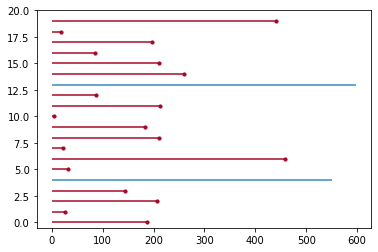